In [25]:
import requests
from bs4 import BeautifulSoup, SoupStrainer
import re
import math
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np
import seaborn as sns
from pprint import pprint

In [26]:
base_url = 'https://english.mubasher.info/markets/EGX/stocks/'

### Getting Companies Listed in EGX from Trading View:

In [27]:
# resp = requests.get('https://www.tradingview.com/symbols/EGX-EGX30/components/')
resp = requests.get('https://www.tradingview.com/markets/stocks-egypt/market-movers-large-cap/')
soup = BeautifulSoup(resp.text)
symbols = []
for i, tag in enumerate(soup.findAll('a', attrs={'class': re.compile('^apply-common-tooltip')})): 
    if(i%2==0 and tag.string != 'EGS923M1C017'):
        symbols.append(tag.string)
symbols

0 : COMI
2 : SWDY
4 : TMGH
6 : MFPC
8 : EAST
10 : ABUK
12 : QNBE
14 : ALCN
16 : ESRS
18 : ETEL
20 : EGAL
22 : EFIH
24 : GPPL
26 : EMFD
28 : HRHO
30 : IRON
32 : EKHO
34 : FWRY
36 : JUFO
38 : FAIT
40 : CIEB
42 : HDBK
44 : ADIB
46 : OCDI
48 : SKPC
50 : EFID
52 : TAQA
54 : PHDC
56 : BTFH
58 : EGCH
60 : GBCO
62 : ORHD
64 : EXPA
66 : ORWE
68 : HELI
70 : EGSA
72 : AMOC
74 : RAYA
76 : CLHO
78 : EFIC
80 : SUGR
82 : ELEC
84 : SCEM
88 : MTIE
90 : MASR
92 : MHOT
94 : SAUD
96 : MOIL
98 : CIRA
100 : SCTS
102 : CANA
104 : TALM
106 : EGAS
108 : PHAR
110 : EGBE
112 : SPHT
114 : ISPH
116 : EGTS
118 : CSAG
120 : OLFI
122 : GDWA
124 : ATQA
126 : CNFN
128 : POUL
130 : CICH
132 : BINV
134 : RMDA
136 : DOMT
138 : ARCC
140 : ISMQ
142 : MPRC
144 : SAIB
146 : ZMID
148 : ACRO
150 : MICH
152 : MOIN
154 : PRDC
156 : PHTV
158 : ENGC
160 : CCAP
162 : MFSC
164 : NAHO
166 : BIOC
168 : DSCW
170 : GSSC
172 : CFGH
174 : AMES
176 : ARAB
178 : MBSC
180 : SPIN
182 : IFAP
184 : WCDF
186 : ASCM
188 : MCQE
190 : OIH
192 : KZPC

['COMI',
 'SWDY',
 'TMGH',
 'MFPC',
 'EAST',
 'ABUK',
 'QNBE',
 'ALCN',
 'ESRS',
 'ETEL',
 'EGAL',
 'EFIH',
 'GPPL',
 'EMFD',
 'HRHO',
 'IRON',
 'EKHO',
 'FWRY',
 'JUFO',
 'FAIT',
 'CIEB',
 'HDBK',
 'ADIB',
 'OCDI',
 'SKPC',
 'EFID',
 'TAQA',
 'PHDC',
 'BTFH',
 'EGCH',
 'GBCO',
 'ORHD',
 'EXPA',
 'ORWE',
 'HELI',
 'EGSA',
 'AMOC',
 'RAYA',
 'CLHO',
 'EFIC',
 'SUGR',
 'ELEC',
 'SCEM',
 'MTIE',
 'MASR',
 'MHOT',
 'SAUD',
 'MOIL',
 'CIRA',
 'SCTS',
 'CANA',
 'TALM',
 'EGAS',
 'PHAR',
 'EGBE',
 'SPHT',
 'ISPH',
 'EGTS',
 'CSAG',
 'OLFI',
 'GDWA',
 'ATQA',
 'CNFN',
 'POUL',
 'CICH',
 'BINV',
 'RMDA',
 'DOMT',
 'ARCC',
 'ISMQ',
 'MPRC',
 'SAIB',
 'ZMID',
 'ACRO',
 'MICH',
 'MOIN',
 'PRDC',
 'PHTV',
 'ENGC',
 'CCAP',
 'MFSC',
 'NAHO',
 'BIOC',
 'DSCW',
 'GSSC',
 'CFGH',
 'AMES',
 'ARAB',
 'MBSC',
 'SPIN',
 'IFAP',
 'WCDF',
 'ASCM',
 'MCQE',
 'OIH',
 'KZPC',
 'MIPH',
 'LCSW',
 'ACGC']

In [28]:
div_tags = SoupStrainer(attrs={'class': re.compile('^stock-overview')})

In [29]:
soup = BeautifulSoup(resp.text, 'lxml', parse_only=div_tags)
print(soup.prettify())

<!DOCTYPE html>



### Defining Filtering Criteria

In [30]:
def has_book_value(tag):
    return tag.string and re.compile("^Book Value").search(tag.string.get_text())

def has_market_cap(tag):
    return tag.string and re.compile("Market Cap").search(tag.string.get_text())

def has_total_shares(tag):
    return tag.string and re.compile("Current Total Shares").search(tag.string.get_text())
def has_eps(tag):
    return tag.string and re.compile("EPS").search(tag.string.get_text())

#### Defining DataFrame Columns List

In [31]:
symbols_list = []
update_dates = []
ratios = []
names = []
EPS = []
prices = []
book_values =[]

### Scraping The Page OF Each Company

In [32]:
for symbol in symbols:
    resp = requests.get(base_url+symbol)
    div_tags = SoupStrainer(attrs={'class': re.compile('^stock-overview')})
    soup = BeautifulSoup(resp.text, 'lxml', parse_only=div_tags)
    book_value_span = soup.find_all(has_book_value)[0]
    
    eps_span = soup.find_all(has_eps)[0]
    quarter = book_value_span.find_next_sibling('span').find('span', class_='market-summary__date').string.get_text()
    
    book_value = float(book_value_span.find_next_sibling('span').find('span', class_=re.compile('^number')).string.replace(',',''))
    
    currency = book_value_span.find_next_sibling('span').find('span', string='Egyptian Pound')

                                                              
    eps = float(eps_span.find_next_sibling('span').find('span', class_=re.compile('^number')).string.get_text())
    
    h1_tags = SoupStrainer('h1')
    soup = BeautifulSoup(resp.text, 'lxml', parse_only=h1_tags)
    name = soup.find('h1').string
 

    
    price_tags = SoupStrainer('div', attrs={'class': re.compile('^market-summary__last-price')})
    soup = BeautifulSoup(resp.text, 'lxml', parse_only=price_tags)
    last_price = float(soup.find().string)
    if book_value != 0 and currency != None:
        p2B = round(last_price/book_value,2)
        if p2B < 1 and p2B > 0:
            symbols_list.append(symbol)
            update_dates.append(quarter.replace('\n', ' ').strip("Based on: "))
            ratios.append(p2B)
            names.append(name)
            EPS.append(eps)
            prices.append(last_price)
            book_values.append(book_value)
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### Loading The Data to Pandas Data Frame:

In [33]:
data = {'Company': names, 'Symbol': symbols_list,'EPS': EPS, 'Price':prices,'Book Value': book_values, 'P/B': ratios, 'Date of Book Value Update': update_dates}

df = pd.DataFrame(data)
df['year'] = df['Date of Book Value Update'].str[-4:]
df['Quarter'] = df['Date of Book Value Update'].str.split().str[0]
df['Company'] = df['Company'].str.split().str[:-1].str.join(' ')
quarter_order = ['First', 'Second', 'Third', 'Fourth']
df['Quarter'] = pd.Categorical(df['Quarter'], categories=quarter_order, ordered=True)
df = df.sort_values(by=['year','Quarter'], ascending=False)
df = df[['Company', 'Symbol', 'P/B','Price','Book Value','Date of Book Value Update']]
df = df.reset_index(drop=True)
df



,Company,Symbol,P/B,Price,Book Value,Date of Book Value Update
0,Misr Hotels,MHOT,0.81,22.05,27.36,Third Quarter 2024
1,Arab Cotton Ginning,ACGC,0.93,6.62,7.09,Third Quarter 2024
2,Qatar National Bank,QNBE,0.83,29.65,35.84,Second Quarter 2024
3,Emaar Misr for Development SAE,EMFD,0.82,7.86,9.57,Second Quarter 2024
4,Export Development Bank of Egypt,EXPA,0.70,15.46,22.23,Second Quarter 2024
5,Oriental Weavers Carpet,ORWE,0.88,22.89,25.90,Second Quarter 2024
6,Al Baraka Bank - Egypt,SAUD,0.84,12.38,14.81,Second Quarter 2024
7,Suez Canal Bank ASE,CANA,0.78,15.22,19.55,Second Quarter 2024
8,CI Capital Holding For Financial Investments,CICH,0.82,5.22,6.36,Second Quarter 2024
9,B Investments Holdings,BINV,0.94,22.49,23.91,Second Quarter 2024


### Plotting Book Value Vs Price

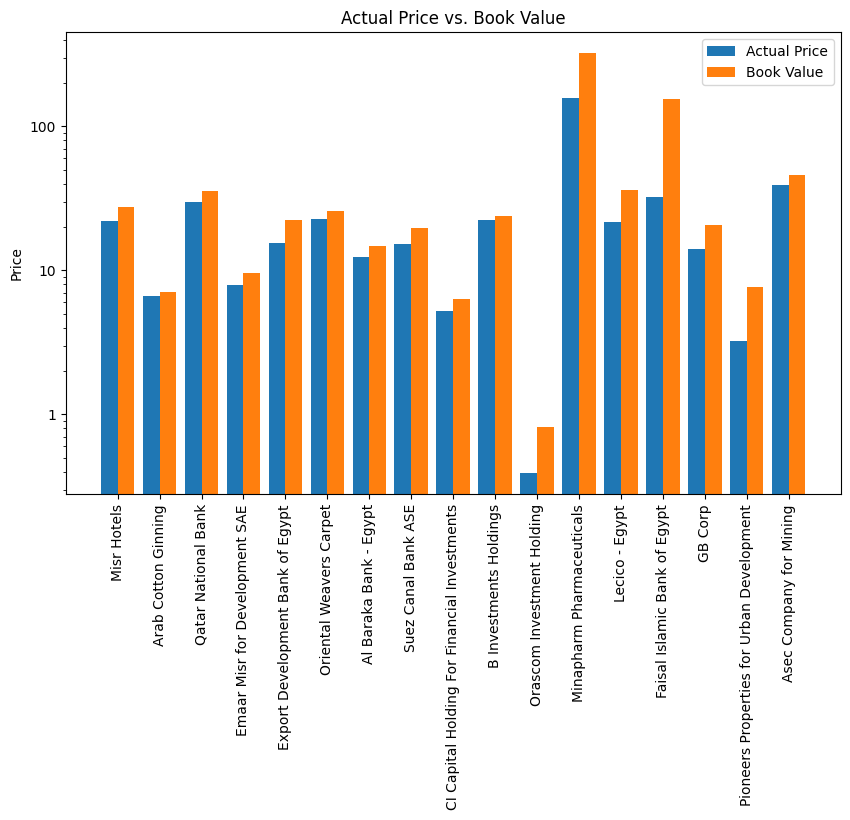

In [34]:
fig, ax = plt.subplots(figsize=(10,6))

x = np.arange(len(df))
ax.set_xticks(x)
ax.set_xticklabels(df['Company'], rotation='vertical')

ax.bar(x-0.2, df['Price'], width=0.4, label='Actual Price')
ax.bar(x+0.2, df['Book Value'], width=0.4, label='Book Value')

ax.set_ylabel('Price')

ax.set_title('Actual Price vs. Book Value')

plt.legend()
plt.yscale('log')

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax.yaxis.set_major_formatter(formatter)



plt.show()
